# Lecture 5

* Neural networks
* XOR problem
* Make\_moons data

Import necessary libraries:

In [1]:
import numpy as np
import random
import math
import sklearn.datasets as ds
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

from nnvisual import *

# Neural networks

We have implemented the following functions: ```sigmoid()``` is an activation function, ```forward()``` implements forward propagation step, ```backward()``` implements backpropagation step. The function ```plot_decision_boundary()``` draws the decision boundary for two classes. The function ```train_neural_network()``` runs the main loop of forward and backward propagations, and the function ```predict_neural_network()``` runs the forward loop to obtain the predictions. Notice that we have added the regularization term, which means that instead of the loss function (we will talk about the regularization techniques later in our lectures):
$$
J (\theta) = -\dfrac{1}{m} \sum\limits_{i=1}^{m} \left(y^{(i)} \ln h_{\theta} (x^{(i)}) + (1-y^{(i)}) \ln (1 - h_{\theta} (x^{(i)}))\right)
$$
we minimize the function
$$
J (\theta) = -\dfrac{1}{m} \left(\sum\limits_{i=1}^{m} y^{(i)} \ln h_{\theta} (x^{(i)}) + (1-y^{(i)}) \ln (1 - h_{\theta} (x^{(i)}))\right) + \dfrac{\beta}{2} \sum\limits_{k=0}^{K} \sum\limits_{i=1}^{m_{k+1}} \sum\limits_{j=1}^{m_k} \left(\theta_{ij}^{(k)}\right)^2.
$$

In [2]:
def sigmoid(z):
    return 1.0/(1+np.exp(-z))

def forward(X, thetas):
    Xb = np.hstack((np.ones((X.shape[0],1)), X))
    a = np.transpose(Xb)
    alist = [a]
    for i in range(L):
        a = sigmoid(np.dot(thetas[i], a))
        if i < L-1:
            a = np.vstack((np.ones((1, a.shape[1])), a))
        alist.append(a)
    return alist

def backward(a, y, thetas, alpha=0.1, beta=0.01, batch_size=1):
    start = 0
    end = start + batch_size
    while True:
        if end > y.shape[1]:
            end = y.shape[1]
        # a[L] are predictions
        deltas = a[L][:,start:end] - y[:,start:end] 
        for i in range(L-1, -1, -1):
            deltas_prev = np.multiply(
                np.multiply(
                    np.dot(thetas[i].T, deltas), 
                    a[i][:,start:end]), 
                1-a[i][:,start:end])
            step = np.sum(np.array([np.outer(deltas[:,k], a[i][:,start:end][:,k]) 
                                    for k in range(deltas.shape[1])]), 
                          axis=0)
            thetas[i][:,1:] = thetas[i][:,1:] - alpha*step[:,1:] - beta*thetas[i][:,1:]
            thetas[i][:,0] = thetas[i][:,0] - alpha*step[:,0]
            deltas = deltas_prev[1:, :]
        start = end
        end = start + batch_size
        if start == y.shape[1]:
            break
    return thetas

def plot_decision_boundary(X, y, thetas, fig, pos, xmin=-0.1, xmax=1.1, ymin=-0.1, ymax=1.1):
    x1, x2 = np.meshgrid(np.linspace(xmin, xmax, 200),
                         np.linspace(ymin, ymax, 200))
    ypred = forward(np.c_[x1.ravel(), x2.ravel()], thetas)[L][0]
    ypred = ypred.reshape(x1.shape)
    extent = xmin, xmax, ymin, ymax
    
    fig.add_subplot(1,4,pos)
    plt.imshow(ypred, cmap=cm.bwr, alpha=.9, 
               interpolation='bilinear', extent = extent, origin='lower')
    plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm.bwr)

def train_neural_network(X, y, alpha, beta, batch_size, seed, niter):
    ### initialize weights
    thetas = []
    np.random.seed(seed)
    for i in range(L):
        thetas.append(20*(np.random.rand(nn[i+1], nn[i]+1)-0.5))
    print 'Thetas:'
    print thetas
    
    ### the main loop of training
    fig = plt.figure(figsize=(16,32))
    count_plot = 0
    for it in range(niter):
        a = forward(X, thetas)    
        thetas = backward(a, y, thetas, alpha=alpha, beta=beta, batch_size=batch_size)
        if it % round(niter/4) == 0:
            count_plot = count_plot + 1
            plot_decision_boundary(X, y, thetas, fig, count_plot, 
                                   xmin=np.min(X[:,0])-0.1, xmax=np.max(X[:,0])+0.1, 
                                   ymin=np.min(X[:,1])-0.1, ymax=np.max(X[:,1])+0.1)
    plt.show() 
    return thetas

def predict_neural_network(X, thetas):
    return forward(X, thetas)[L][0]

# XOR problem

We use our neural network to solve the famous XOR problem.

| $\mathbf{x_1}$ | $\mathbf{x_2}$ | XOR $\mathbf{(x_1, x_2)}$ |
|-------|-------|------------------------|
| 1     | 1     |     1 |
| 1     | 0     |     0 |
| 0     | 1     |     0 |
| 0     | 0     |     1 |

The XOR function detects if $x_1$ and $x_2$ are the same. The known fact is that it is impossible to solve this problem using logistic regression and we need at least one hidden layer to get correct solution. First, we define our dataset: 4 training examples with XOR as a target variable $y$.

In [3]:
X_train = np.array([[1, 1], [1, 0], [0, 1], [0, 0]]).astype(np.float64)
y_train = np.array([1, 0, 0, 1]).reshape((1, -1))

Define the neural network configuration (the last number is the dimension of $y$):

In [4]:
nn = np.array([X_train.shape[1], 2, y_train.shape[0]]).astype(int)
L = len(nn)-1 # L = number of hidden layers + 1

We are using nnvisual.py code to show how my neural network looks like. This code is modified code from here: https://github.com/miloharper/visualise-neural-network (thanks to miloharper for it). I have changed the orientation of the neural network in the original file.

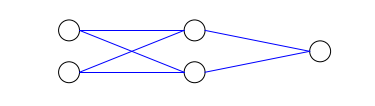

In [5]:
network = NeuralNetwork()
for l in nn:
    network.add_layer(l)
network.draw()

In the final part we are going to check different initializations and different parameters:

Thetas:
[array([[ 1.67236953,  7.19523078,  2.85081229],
       [-8.56741528,  0.63708182,  8.25788355]]), array([[ 5.62926985,  5.52618743,  5.01061296]])]


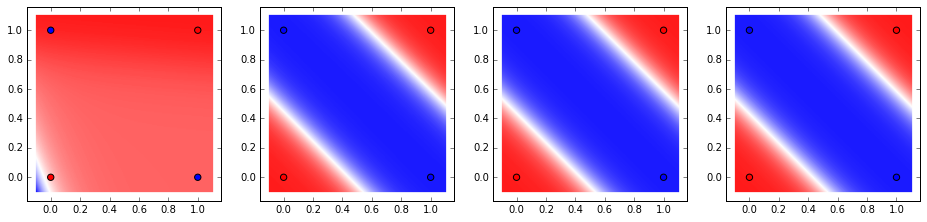

Predictions:


array([ 0.97663021,  0.02344909,  0.0234481 ,  0.97639398])

In [6]:
thetas = train_neural_network(X_train, y_train, 
                              alpha=0.1, beta=0.0001, 
                              batch_size=2, seed=131214, niter=10000)
print "Predictions:"
predict_neural_network(X_train, thetas)

Here the influence of the learning rate alpha. We can see that our neural network cannot find the correct minimum with big learning rate. Notice that in this case all predictions are very close to each other.

Thetas:
[array([[ 1.67236953,  7.19523078,  2.85081229],
       [-8.56741528,  0.63708182,  8.25788355]]), array([[ 5.62926985,  5.52618743,  5.01061296]])]


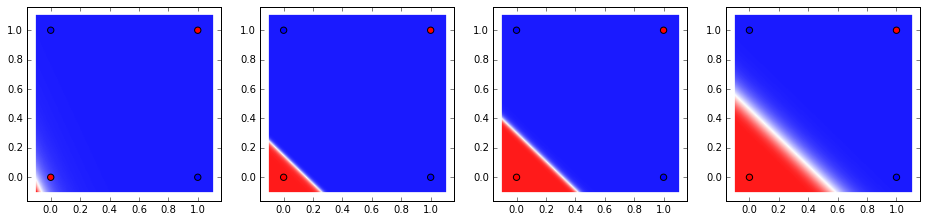

Predictions:


array([ 0.999996,  0.999996,  0.999996,  1.      ])

In [7]:
thetas = train_neural_network(X_train, y_train, 
                              alpha=10.0, beta=0.0001, 
                              batch_size=2, seed=131214, niter=10000)
print "Predictions:"
predict_neural_network(X_train, thetas)

The initialization weights are also very important. The different seed can give different results:

Thetas:
[array([[-6.96736066,  7.37490561,  8.51767526],
       [-0.23173645,  5.30985877, -2.76355142]]), array([[-7.335906  ,  0.43388152,  4.42122827]])]


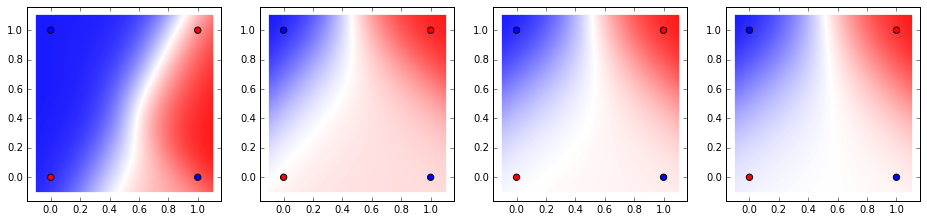

Predictions:


array([ 0.8485083 ,  0.52529168,  0.15702184,  0.46377799])

In [8]:
thetas = train_neural_network(X_train, y_train, 
                              alpha=0.01, beta=0.0001, 
                              batch_size=2, seed=114, niter=10000)
print "Predictions:"
predict_neural_network(X_train, thetas)

The regularization parameter beta is also important. For wrong values of beta the neural network can fail as well:

Thetas:
[array([[ 1.67236953,  7.19523078,  2.85081229],
       [-8.56741528,  0.63708182,  8.25788355]]), array([[ 5.62926985,  5.52618743,  5.01061296]])]


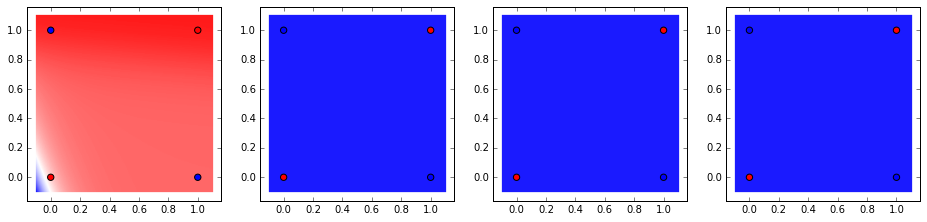

Predictions:


array([ 0.5,  0.5,  0.5,  0.5])

In [9]:
thetas = train_neural_network(X_train, y_train, 
                              alpha=0.1, beta=0.01, 
                              batch_size=2, seed=131214, niter=10000)
print "Predictions:"
predict_neural_network(X_train, thetas)

# Make_moons data

As an another example we consider the ```make_moons``` dataset from ```scikit-learn``` package:

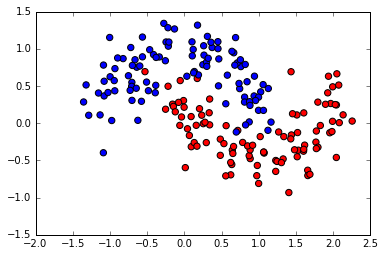

In [10]:
np.random.seed(0)
X_train, y_train = ds.make_moons(200, noise=0.20)
y_train = y_train.reshape((1, -1))
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=cm.bwr)
plt.show()

Initialize our neural network and visualize it:

In [11]:
nn = np.array([X_train.shape[1], 5, y_train.shape[0]]).astype(int)
L = len(nn)-1 # L = number of hidden layers + 1

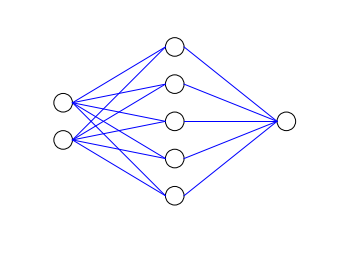

In [12]:
network = NeuralNetwork()
for l in nn:
    network.add_layer(l)
network.draw()

Thetas:
[array([[ 1.22741958, -1.53385074,  4.2008582 ],
       [-3.76905412,  6.57801497,  1.09413825],
       [ 0.05969385, -3.51291599,  6.83412737],
       [-8.07433437, -3.75662311,  2.07674147],
       [-1.92150795, -4.73883283,  2.7290175 ]]), array([[-9.78380152,  1.20918211, -8.0590909 , -2.00016833,  9.60846917,
         9.05818477]])]


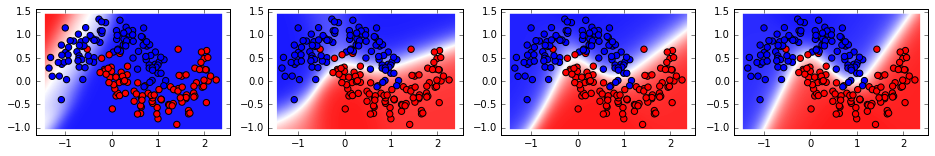

In [13]:
thetas = train_neural_network(X_train, y_train, 
                              alpha=0.01, beta=0.0001, 
                              batch_size=10, seed=1104, niter=1000)

Wrong learning rate:

Thetas:
[array([[ 1.22741958, -1.53385074,  4.2008582 ],
       [-3.76905412,  6.57801497,  1.09413825],
       [ 0.05969385, -3.51291599,  6.83412737],
       [-8.07433437, -3.75662311,  2.07674147],
       [-1.92150795, -4.73883283,  2.7290175 ]]), array([[-9.78380152,  1.20918211, -8.0590909 , -2.00016833,  9.60846917,
         9.05818477]])]


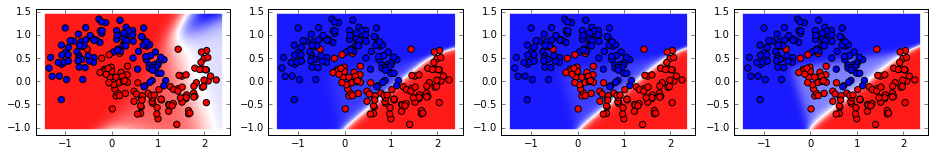

In [14]:
thetas = train_neural_network(X_train, y_train, 
                              alpha=0.1, beta=0.0001, 
                              batch_size=10, seed=1104, niter=1000)

Add more layers to the network:

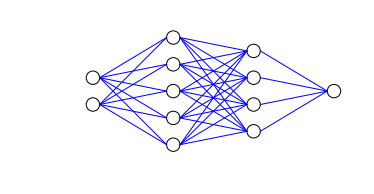

In [15]:
nn = np.array([X_train.shape[1], 5, 4, y_train.shape[0]]).astype(int)
L = len(nn)-1 # L = number of hidden layers + 1
network = NeuralNetwork()
for l in nn:
    network.add_layer(l)
network.draw()

Thetas:
[array([[ 1.22741958, -1.53385074,  4.2008582 ],
       [-3.76905412,  6.57801497,  1.09413825],
       [ 0.05969385, -3.51291599,  6.83412737],
       [-8.07433437, -3.75662311,  2.07674147],
       [-1.92150795, -4.73883283,  2.7290175 ]]), array([[-9.78380152,  1.20918211, -8.0590909 , -2.00016833,  9.60846917,
         9.05818477],
       [ 2.7658245 ,  6.18629069,  5.87405401,  3.1083233 ,  4.18967725,
        -9.62277243],
       [ 7.98004874, -5.70138433, -2.81696969,  1.37023534,  1.63148528,
         2.64712872],
       [ 0.91330808,  5.79962168, -6.87919383,  3.45548887, -4.25206935,
         8.13070444]]), array([[ 1.59582934, -6.12309422, -9.71947835, -6.38006748,  1.21069708]])]


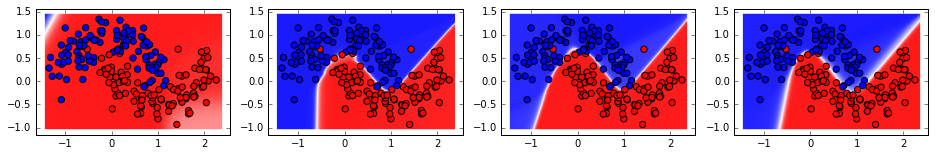

In [16]:
thetas = train_neural_network(X_train, y_train, 
                              alpha=0.1, beta=0.0001, 
                              batch_size=10, seed=1104, niter=1000)